1. maybe run HMM or confidence interval to decide when regime changes and model fails. or add it into screener 
2. Build out screener
3. Make an options screener to screen for alerts and backtested profitability while remaining within regime. 
4. PCA and greeks to optimize features /done
5. Remove lag /done
6. Make the model a triple barrier: make it more robust in labeling / generating correct classes 

Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
Other ideas: HMM screener to detect consistent current option regime 

In [16]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [17]:
datafix = datafix.set_index("Date")


In [18]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [19]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)



In [20]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Assume 'Kalman_Roc' is already in datafix and contains the filtered returns
# Drop NaN values to ensure clean input for the HMM
kalman_roc_values = datafix['Kalman_Roc'].dropna().values.reshape(-1, 1)

# Fit a 2-state Gaussian HMM
hmm_model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000)
hmm_model.fit(kalman_roc_values)

# Predict the hidden states (regimes)
hidden_states = hmm_model.predict(kalman_roc_values)

# Align the states with the original dataframe
states_full = np.full(len(datafix), np.nan)
states_full[datafix['Kalman_Roc'].notna()] = hidden_states

# Append the regime state to the dataframe
datafix['regime_state'] = states_full


In [21]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]
datafix["regimecount"]= datafix["regime_state"].rolling(14).sum()
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [22]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)
# Calculate 14-period moving average of the 'Close' column
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()



In [23]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,regimecount,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-27 19:59:00,15.40,15.50,15.40,15.50,9,15.500000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-30 13:30:00,13.20,15.60,12.95,15.45,282,15.454177,-0.295632,-0.003989,-0.000798,-0.003191,...,-0.056411,NaN,NaN,NaN,NaN,NaN,NaN,-9.163793,NaN,NaN
2025-06-30 13:31:00,15.50,16.55,15.50,16.35,120,16.173759,4.656228,0.064727,0.012307,0.052420,...,0.046462,NaN,NaN,NaN,NaN,NaN,NaN,7.582492,NaN,NaN
2025-06-30 13:32:00,16.00,16.03,15.00,15.06,72,15.518405,-4.051960,0.014920,0.012830,0.002090,...,0.051214,0.013755,NaN,NaN,NaN,NaN,3.932337,8.356002,NaN,NaN
2025-06-30 13:33:00,14.55,14.67,14.40,14.42,26,14.834194,-4.409024,-0.075327,-0.004802,-0.070525,...,-0.008247,0.029810,NaN,NaN,NaN,NaN,8.491074,-1.323454,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02 19:55:00,7.80,8.00,7.60,7.75,35,7.339632,1.875176,-0.083195,-0.165737,0.082542,...,-0.000172,-0.002191,0.505278,-0.003130,2.0,-0.373300,-0.595575,-0.008880,58.481189,40.440338
2025-07-02 19:56:00,7.74,7.95,7.72,7.95,171,7.499776,2.181896,-0.028602,-0.138310,0.109709,...,0.003025,-0.001426,0.505236,-0.001570,3.0,-0.152354,-0.378364,0.511543,62.520329,42.455753
2025-07-02 19:57:00,7.90,7.98,7.85,7.85,216,7.599704,1.332413,0.006520,-0.109344,0.115864,...,0.005109,0.002654,0.505349,0.000891,4.0,0.196011,0.780139,0.850735,59.408285,43.969085


In [24]:
#MACD IV
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDvol'] = macd
    df['Signalvol'] = signal_line
    df['MACD_Histvol'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='IV_garch_vol', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histvol']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

datafix['MACDROCvol'] = macdata['MACD_Histvol'].pct_change()

In [25]:
#MACD KALMAN
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDkalman'] = macd
    df['Signalkalman'] = signal_line
    df['MACD_Histkalman'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Kalman', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histkalman']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0
datafix['MACDROCkal'] = macdata['MACD_Histkalman'].pct_change()
datafix['MACDROC'] = macdata['MACD_Hist'].pct_change()
datafix['VolumeSMA9'] = datafix['Volume'].rolling(9).mean()
datafix['VolumeSMA26'] = datafix['Volume'].rolling(26).mean()

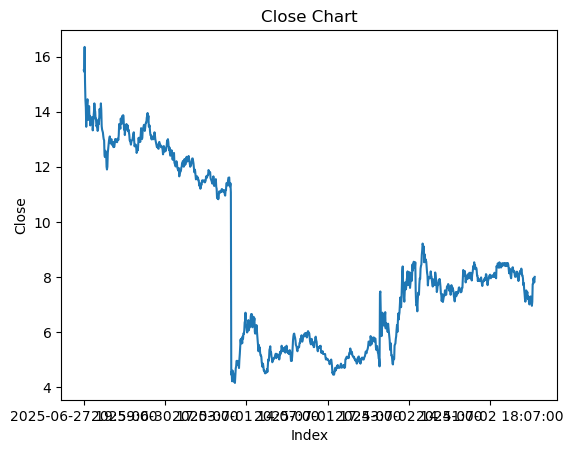

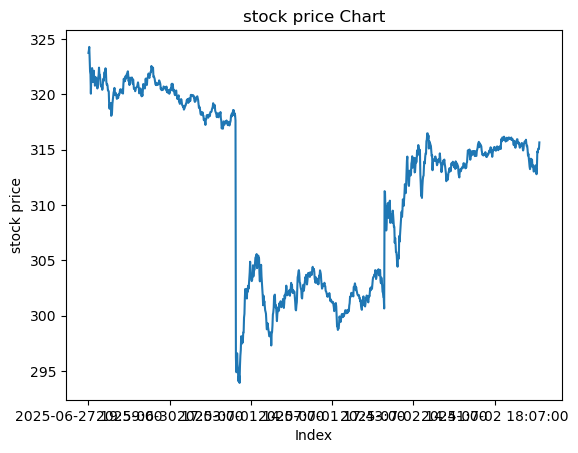

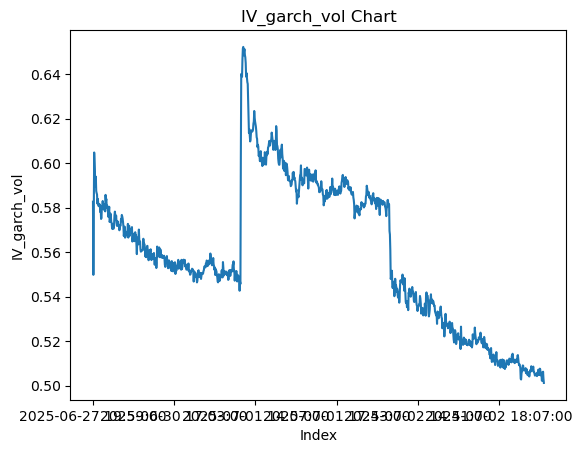

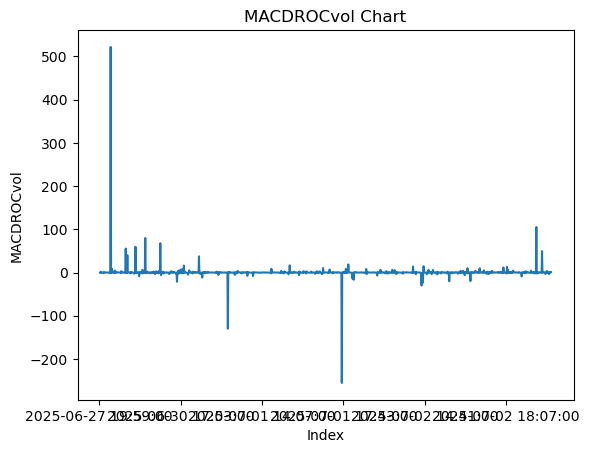

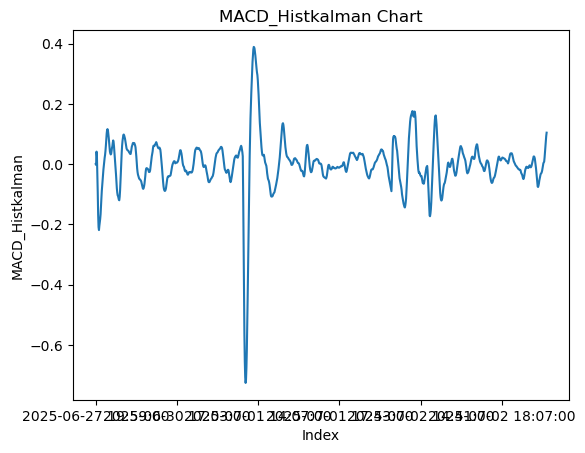

In [26]:
plot('Close')
plot('stock price')
plot('IV_garch_vol')
plot('MACDROCvol')
plot('MACD_Histkalman')

In [27]:
lag = 9 
# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()

# assign other variables -- stocksma can be a screener filter along with volume and implied volatility 
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 

# no MACDs 
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

In [28]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Calculate daily log returns from the 'Close' column
datafix['log_return'] = np.log(datafix['Close'] / datafix['Close'].shift(1))
returns = datafix['log_return'].dropna().values.reshape(-1, 1)

# Fit HMM (e.g., with 3 states)
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
model.fit(returns)

# Predict hidden states for each day
hidden_states = model.predict(returns)

# Add hidden states to your DataFrame (align index after dropna)
datafix = datafix.iloc[1:]  # because the first return is NaN
datafix['hmm_state'] = hidden_states


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/2681209349.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['hmm_state'] = hidden_states


In [29]:
# Random forest settings 
multiplier = 1 # sensitivity multiplier for dynamic threshold for 1 or 0 signal stdevs from mean return df1
lookahead = 15  # Number of bars to look ahead for the price move df30
stat_window = 10  # Rolling window for statistics (e.g., 1 year of trading days) df20
buy_thresh = 0.20  # Threshold for buy signal(probability of rf outcome) df.2
sell_thresh = -0.20  # Threshold for sell signal(probability of rf outcome) df-.2
backtest_ma = 10 # Buy/sell moving average for rolling RF signal and backtest | keep same as stat window df20

In [30]:
#BUY RF and features
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Calculate the future maximum close price within the lookahead window
future_max_close = datafix['Close'].shift(-1).rolling(window=lookahead, min_periods=1).max()

# Calculate percent increase from current close to future max close
pct_increase = (future_max_close - datafix['Close']) / datafix['Close']

# Compute rolling mean and std of past percent increases (shift(1) prevents lookahead bias)
rolling_mean = pct_increase.rolling(window=stat_window, min_periods=5).mean()
rolling_std = pct_increase.rolling(window=stat_window, min_periods=5).std()

# Dynamic threshold: mean + 2*std, calculated from past values only
dynamic_threshold = rolling_mean + multiplier * rolling_std

# Label as 1 if current percent increase > dynamic threshold, else 0
datafix['BuyLabel'] = (pct_increase > dynamic_threshold).astype(int)

# Calculate rolling averages for features
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# Define features based on your strategy
features = [
    "kalmansma",
    "IV_garch_volsma",
    "IV_garch_vol",
    "VolumeSMA3",
    "VolumeSMA9",
    #"VolumeSMA26",
    "Close",
    "stock price", 
    "MACD_Hist",
    "days_to_expiry", 
    "hmm_state",
    #"strike"
]

# Drop rows with missing values in features or label
model_data = datafix.dropna(subset=features + ["BuyLabel"])

X = model_data[features]
y = model_data["BuyLabel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.6)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict signals
model_data["Predicted_Signal"] = rf.predict(X)
datafix["Predicted_Signal"] = rf.predict(datafix[features])


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/568462292.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['BuyLabel'] = (pct_increase > dynamic_threshold).astype(int)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/568462292.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/568462292.py:25: SettingWithCopyWarning: 
A value is trying to

In [31]:
# SELL RF
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Calculate the future minimum close price within the lookahead window
future_min_close = datafix['Close'].shift(-1).rolling(window=lookahead, min_periods=1).min()

# Calculate percent decrease from current close to future min close
pct_decrease = (future_min_close - datafix['Close']) / datafix['Close']

# Compute rolling mean and std of past percent decreases
# Use shift(1) so that the current value is not included in the calculation (prevents lookahead bias)
rolling_mean = pct_decrease.shift(1).rolling(window=stat_window, min_periods=5).mean()
rolling_std = pct_decrease.shift(1).rolling(window=stat_window, min_periods=5).std()

# Dynamic threshold: mean - 2*std, calculated from past values only
dynamic_threshold = rolling_mean - multiplier * rolling_std

# Label as 1 if current percent decrease < dynamic threshold, else 0
datafix['SellLabel'] = (pct_decrease < dynamic_threshold).astype(int)

# Drop rows with missing values in features or label
model_data_sell = datafix.dropna(subset=features + ["SellLabel"])

X_sell = model_data_sell[features]
y_sell = model_data_sell["SellLabel"]

X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(
    X_sell, y_sell, shuffle=False, test_size=0.6
)

rf_sell = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sell.fit(X_train_sell, y_train_sell)

# Predict signals
model_data_sell["Predicted_Sell"] = rf_sell.predict(X_sell)
datafix["Predicted_Sell"] = rf_sell.predict(datafix[features])


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/753376509.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['SellLabel'] = (pct_decrease < dynamic_threshold).astype(int)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/753376509.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_sell["Predicted_Sell"] = rf_sell.predict(X_sell)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/753376509.py:40: SettingWithCopyWarning: 
A value is trying t

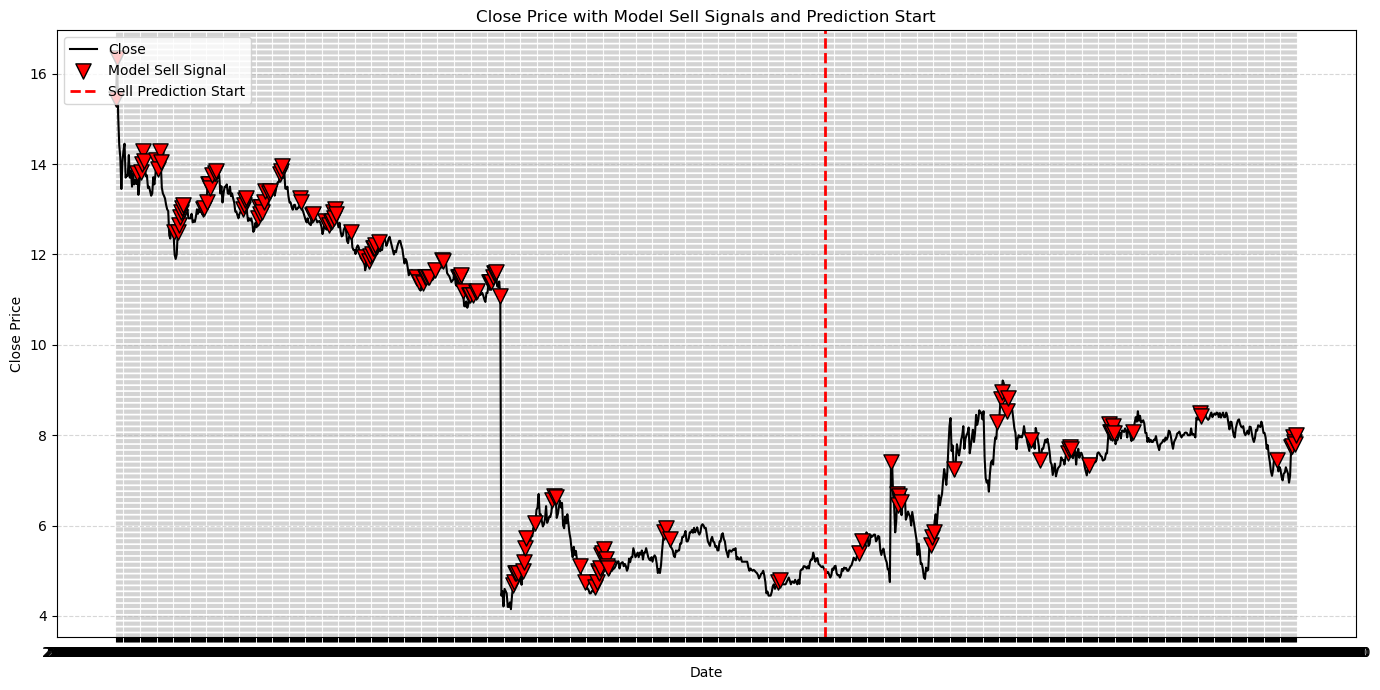

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot all model sell signals as red downward triangles
sell_signals = datafix[datafix["Predicted_Sell"] == 1]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Model Sell Signal",
    zorder=3
)

# Find the index where sell predictions begin (start of test set)
split_idx_sell = int(len(datafix) * 0.6)  # 40% train, 60% test as in your code
split_date_sell = datafix.index[split_idx_sell]

# Draw a vertical line at the prediction start
plt.axvline(x=split_date_sell, color='red', linestyle='--', linewidth=2, label='Sell Prediction Start')

plt.title("Close Price with Model Sell Signals and Prediction Start")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Use automatic date formatting for clarity

plt.tight_layout()
plt.show()


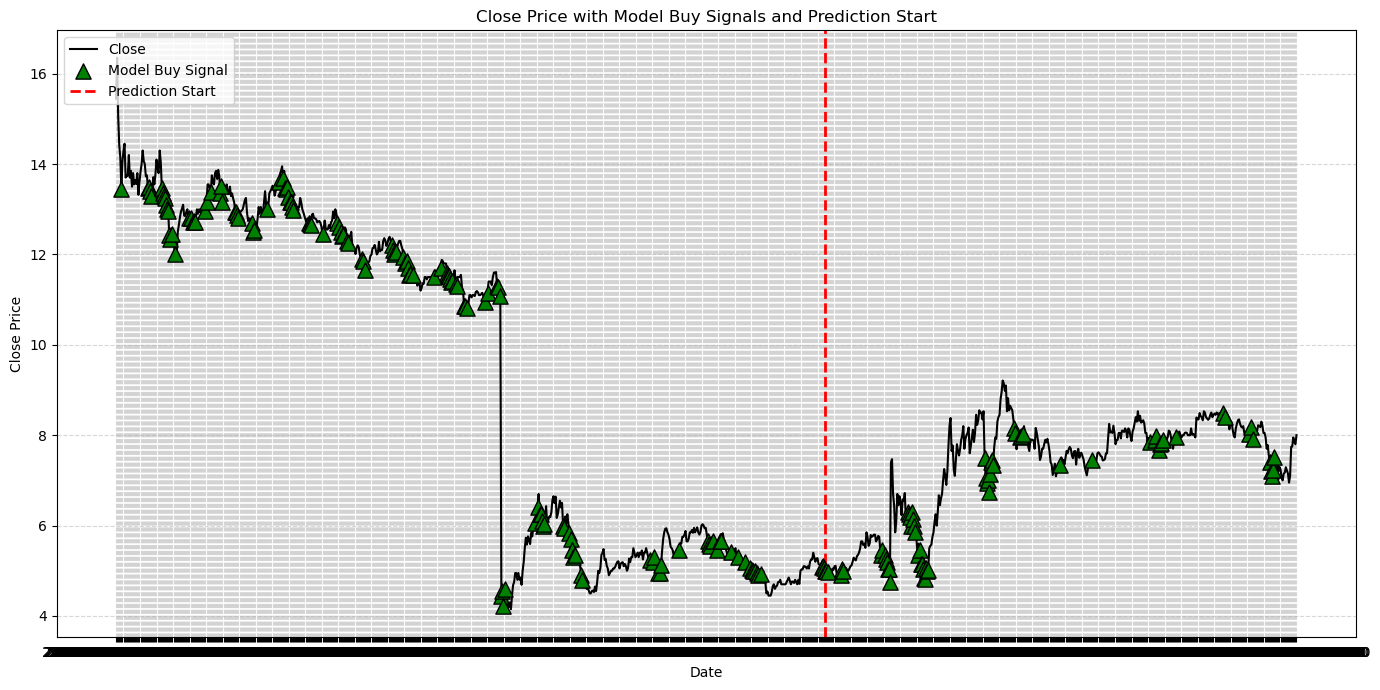

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot all model buy signals as green upward triangles
buy_signals = datafix[datafix["Predicted_Signal"] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Model Buy Signal",
    zorder=3
)

# Find the index where predictions begin (start of test set)
split_idx = int(len(datafix) * 0.6)  # 80% train, 20% test
split_date = datafix.index[split_idx]

# Draw a vertical line at the prediction start
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Prediction Start')

plt.title("Close Price with Model Buy Signals and Prediction Start")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Use automatic date formatting for clarity

plt.tight_layout()
plt.show()


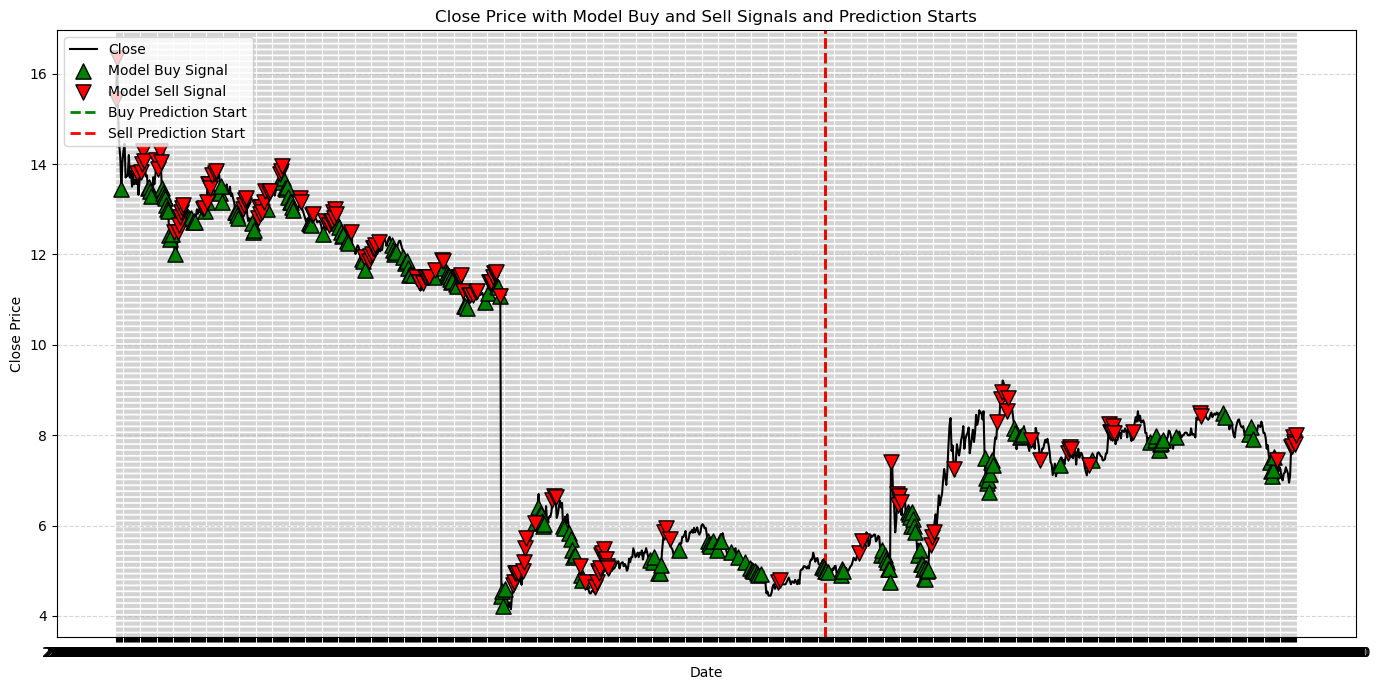

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Predicted_Signal"] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Model Buy Signal",
    zorder=3
)

# Plot sell signals (red downward triangle)
sell_signals = datafix[datafix["Predicted_Sell"] == 1]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Model Sell Signal",
    zorder=3
)

# Draw vertical lines where out-of-sample predictions begin
# For buy model (adjust split as per your test_size)
split_idx_buy = int(len(datafix) * 0.6)  # 40% train, 60% test as in your code above
split_date_buy = datafix.index[split_idx_buy]
plt.axvline(x=split_date_buy, color='green', linestyle='--', linewidth=2, label='Buy Prediction Start')

# For sell model (assuming same split, otherwise adjust accordingly)
split_idx_sell = int(len(datafix) * 0.6)
split_date_sell = datafix.index[split_idx_sell]
plt.axvline(x=split_date_sell, color='red', linestyle='--', linewidth=2, label='Sell Prediction Start')

plt.title("Close Price with Model Buy and Sell Signals and Prediction Starts")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()


In [35]:
# Get probabilities (assuming binary classification, class 1 is buy/sell)
datafix["Buy_Prob"] = rf.predict_proba(datafix[features])[:, 1]
datafix["Sell_Prob"] = rf_sell.predict_proba(datafix[features])[:, 1]

# Weighted difference (you can adjust the weights)
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]

# Define thresholds for action
def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/1026376256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Buy_Prob"] = rf.predict_proba(datafix[features])[:, 1]
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/1026376256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Sell_Prob"] = rf_sell.predict_proba(datafix[features])[:, 1]
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/1026376256.py:6: SettingWithCopyWarning: 
A value is tryi

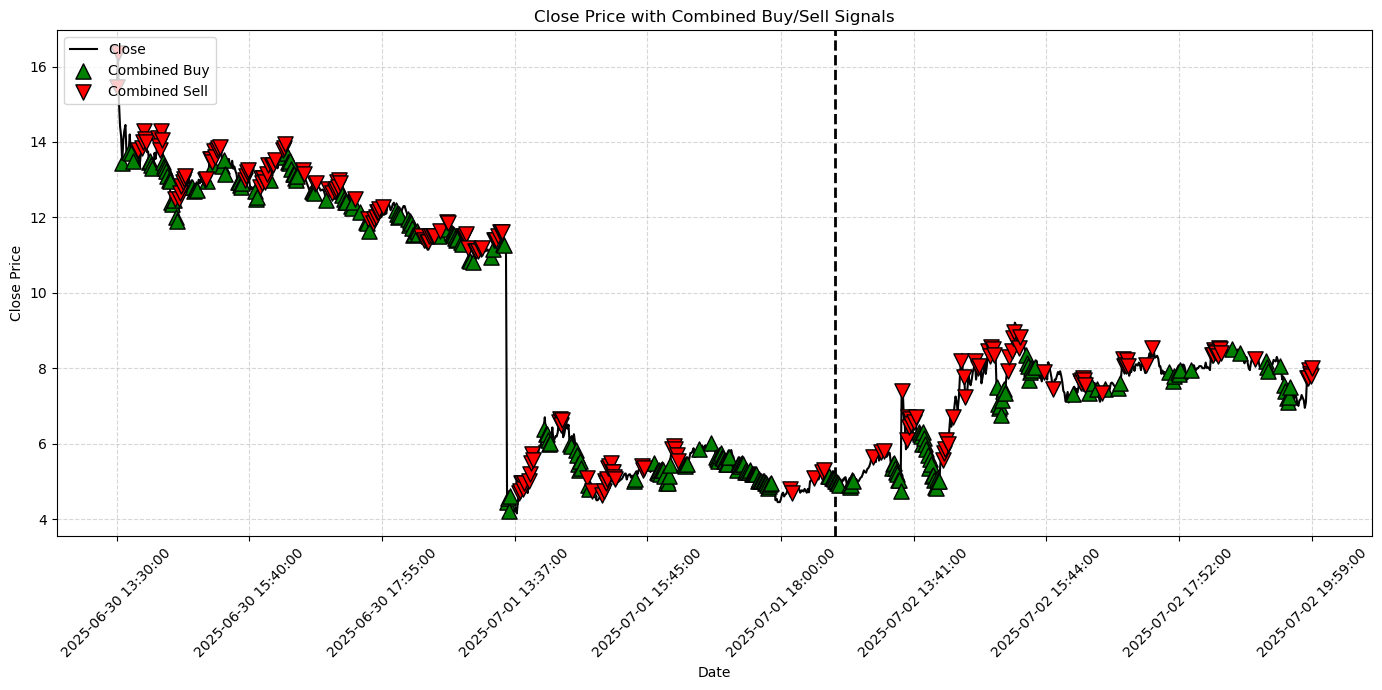

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot combined buy signals (green upward triangle)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Combined Buy",
    zorder=3
)

# Plot combined sell signals (red downward triangle)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Combined Sell",
    zorder=3
)

plt.title("Close Price with Combined Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.6)
split_date_bar = datafix.index[split_idx_bar]
plt.axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label='Prediction Start')

# Show only 10 x-axis date labels (no .strftime() since index is string)
n_labels = 10
if len(datafix.index) > n_labels:
    idxs = np.linspace(0, len(datafix.index) - 1, n_labels, dtype=int)
    dates = [datafix.index[i] for i in idxs]
    plt.xticks(dates, dates, rotation=45)
else:
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/3149753067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_32472/3149753067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=backtest_ma, center=False).mean()


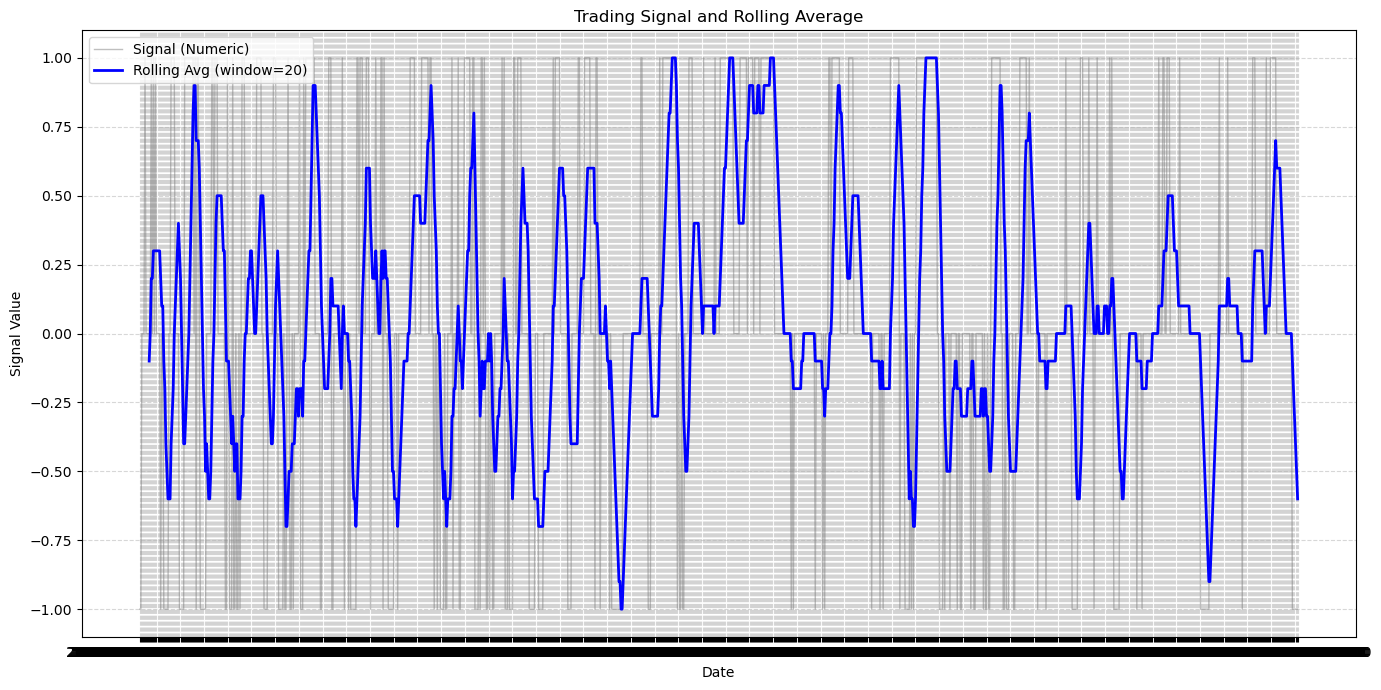

In [37]:
# Map signals to numeric: buy=1, sell=-1, hold=0 (example)
signal_map = {"buy": 1, "sell": -1, "hold": 0}
datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)

# Rolling average
datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=backtest_ma, center=False).mean()

# Plot similarly as above
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the numeric signal (buy=1, sell=-1, hold=0)
plt.plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)

# Plot the rolling average of the signal
plt.plot(
    datafix.index,
    datafix["Rolling_Signal_Num"],
    label=f"Rolling Avg (window={20})",
    color="blue",
    linewidth=2
)

plt.title("Trading Signal and Rolling Average")
plt.xlabel("Date")
plt.ylabel("Signal Value")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(16, 28), sharex=False, sharey=False)

# --- Full range charts (first two) ---
axes[0].plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[0].plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[0].set_ylabel("Signal Value")
axes[0].set_title("Trading Signal and Rolling Average")
axes[0].legend(loc="upper left")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
axes[1].scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
axes[1].scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[1].set_ylabel("Close Price")
axes[1].set_title("Close Price with Combined Buy/Sell Signals")
axes[1].legend(loc="upper left")
axes[1].grid(True, linestyle='--', alpha=0.5)
split_idx_bar = int(len(datafix) * 0.6)
split_date_bar = datafix.index[split_idx_bar]
axes[1].axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label='Prediction Start')

# --- Last 60 datapoints charts (independent axes) ---
last60 = datafix.tail(60)
axes[2].plot(last60.index, last60["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[2].plot(last60.index, last60["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[2].set_ylabel("Signal Value")
axes[2].set_title("Last 60 Trading Signal and Rolling Average")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle='--', alpha=0.5)

axes[3].plot(last60.index, last60["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last60 = last60[last60["Combined_Signal"] == "buy"]
axes[3].scatter(buy_signals_last60.index, buy_signals_last60["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last60 = last60[last60["Combined_Signal"] == "sell"]
axes[3].scatter(sell_signals_last60.index, sell_signals_last60["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[3].set_ylabel("Close Price")
axes[3].set_title("Last 60 Close Price with Combined Buy/Sell Signals")
axes[3].legend(loc="upper left")
axes[3].grid(True, linestyle='--', alpha=0.5)

# --- Last 10 datapoints charts (independent axes) ---
last10 = datafix.tail(10)
axes[4].plot(last10.index, last10["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[4].plot(last10.index, last10["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[4].set_ylabel("Signal Value")
axes[4].set_title("Last 10 Trading Signal and Rolling Average")
axes[4].legend(loc="upper left")
axes[4].grid(True, linestyle='--', alpha=0.5)

axes[5].plot(last10.index, last10["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last10 = last10[last10["Combined_Signal"] == "buy"]
axes[5].scatter(buy_signals_last10.index, buy_signals_last10["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last10 = last10[last10["Combined_Signal"] == "sell"]
axes[5].scatter(sell_signals_last10.index, sell_signals_last10["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[5].set_ylabel("Close Price")
axes[5].set_title("Last 10 Close Price with Combined Buy/Sell Signals")
axes[5].legend(loc="upper left")
axes[5].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [ ]:
datafix.tail(5)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,VolumeSMA3,Predicted_Signal,SellLabel,Predicted_Sell,Buy_Prob,Sell_Prob,Combined_Score,Combined_Signal,Signal_Num,Rolling_Signal_Num
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-02 19:48:00,5.7,5.7,5.7,5.7,3,5.531330,1.456433,0.090078,0.023208,0.066870,...,1.666667,0,1,1,0.10,0.79,-0.69,sell,-1,-0.9
2025-07-02 19:50:00,5.6,5.6,5.6,5.6,3,5.566488,0.635613,0.099430,0.038452,0.060978,...,2.333333,0,1,1,0.10,0.84,-0.74,sell,-1,-0.9
2025-07-02 19:51:00,5.7,5.7,5.7,5.7,1,5.619449,0.951429,0.113601,0.053482,0.060119,...,2.333333,0,1,1,0.09,0.84,-0.75,sell,-1,-0.9
2025-07-02 19:53:00,5.5,5.5,5.5,5.5,1,5.607008,-0.221403,0.107454,0.064276,0.043178,...,1.666667,0,0,1,0.09,0.78,-0.69,sell,-1,-0.9
2025-07-02 19:55:00,5.5,5.5,5.5,5.5,1,5.595807,-0.199764,0.101414,0.071704,0.029711,...,1.000000,0,0,1,0.04,0.71,-0.67,sell,-1,-0.9


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_27428/508776490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['ROC'] = datafix['Rolling_Signal_Num'].diff(n)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_27428/508776490.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['Trade_Signal'] = stateful_signals(datafix['ROC'], datafix['Rolling_Signal_Num'])


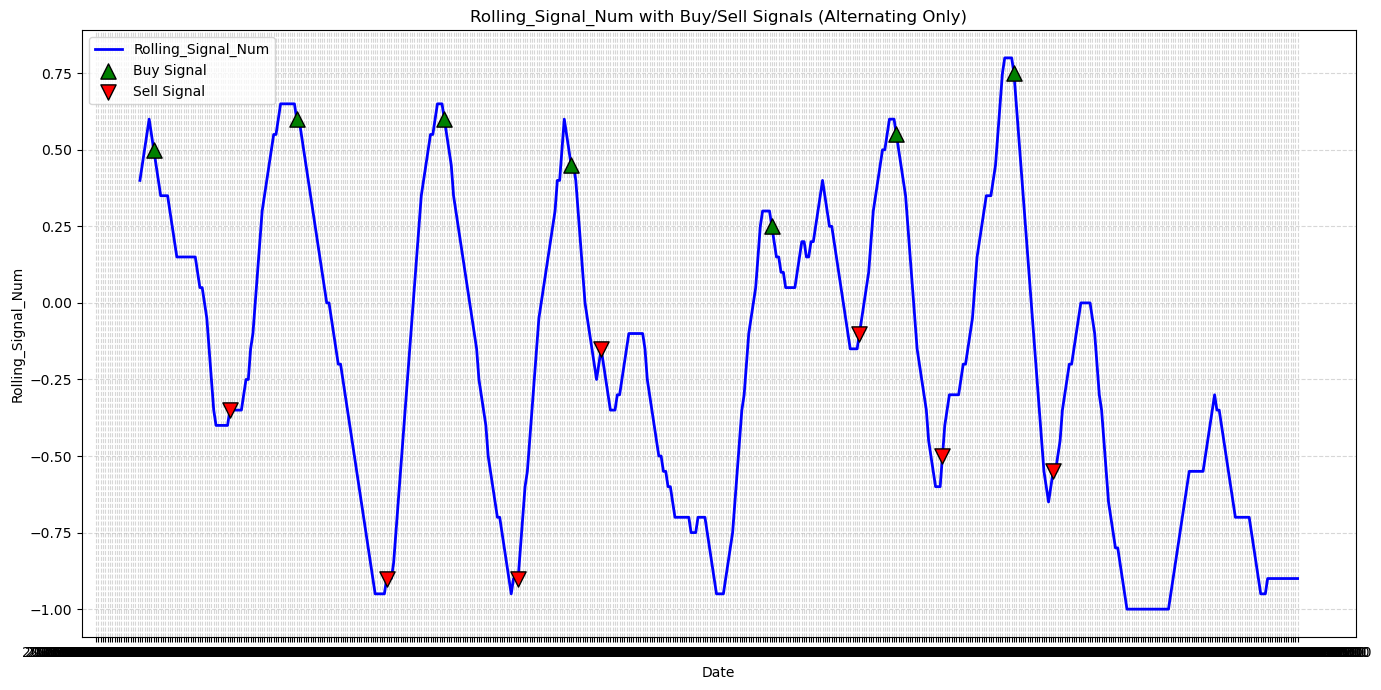

In [ ]:
n = 3  # or whatever period you want
datafix['ROC'] = datafix['Rolling_Signal_Num'].diff(n)

def stateful_signals(roc, rolling_signal):
    signals = []
    position = 0  # 0 = flat, 1 = long (buy active), -1 = short (sell active)
    for r, s in zip(roc, rolling_signal):
        if position == 0:
            if (r < 0) and (s > 0):
                signals.append(1)    # Buy
                position = 1
            elif (r > 0) and (s < 0):
                signals.append(-1)   # Sell
                position = -1
            else:
                signals.append(0)    # Hold
        elif position == 1:
            if (r > 0) and (s < 0):
                signals.append(-1)   # Sell
                position = -1
            else:
                signals.append(0)    # Hold
        elif position == -1:
            if (r < 0) and (s > 0):
                signals.append(1)    # Buy
                position = 1
            else:
                signals.append(0)    # Hold
    return signals

datafix['Trade_Signal'] = stateful_signals(datafix['ROC'], datafix['Rolling_Signal_Num'])
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Rolling_Signal_Num line
plt.plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling_Signal_Num", color="blue", linewidth=2)

# Plot buy signals (green upward triangles)
buy_signals = datafix[datafix['Trade_Signal'] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Rolling_Signal_Num"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Buy Signal",
    zorder=3
)

# Plot sell signals (red downward triangles)
sell_signals = datafix[datafix['Trade_Signal'] == -1]
plt.scatter(
    sell_signals.index,
    sell_signals["Rolling_Signal_Num"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Sell Signal",
    zorder=3
)

plt.title("Rolling_Signal_Num with Buy/Sell Signals (Alternating Only)")
plt.xlabel("Date")
plt.ylabel("Rolling_Signal_Num")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Total Return (Last 40%): -16.87%


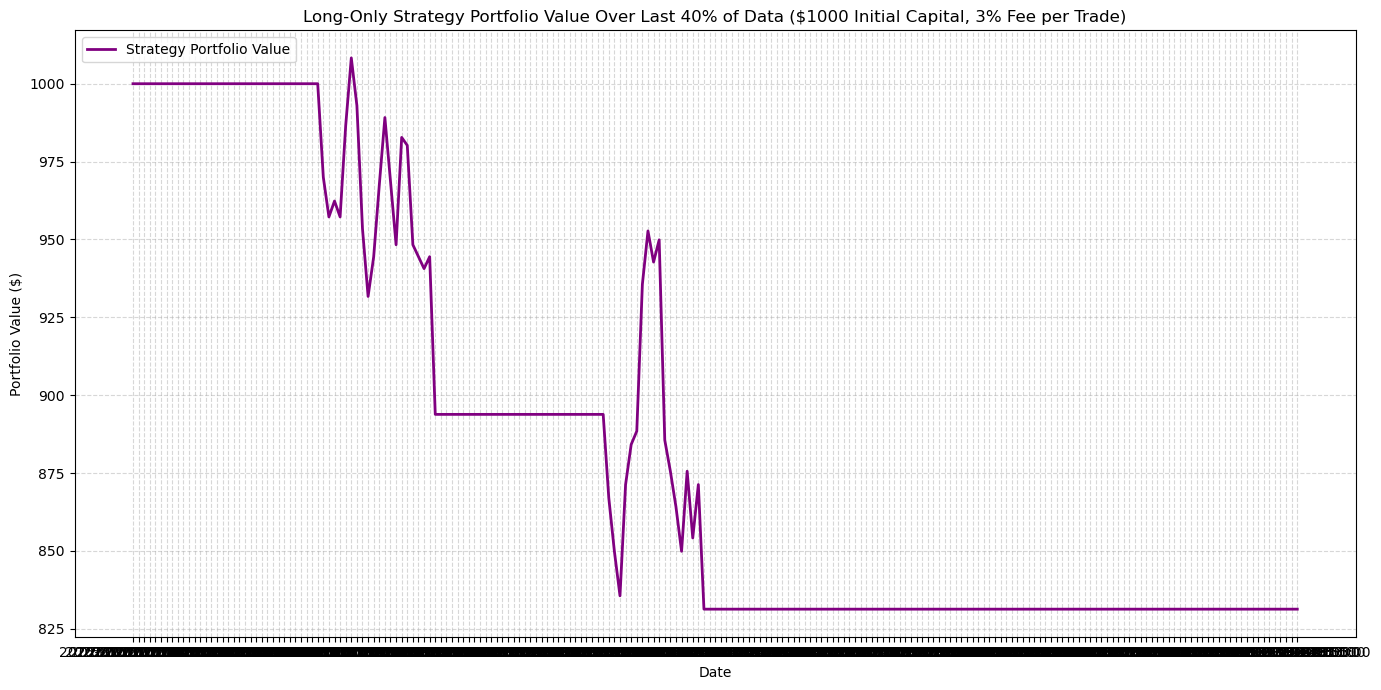

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Slice the last 40% of the data
start_idx = int(len(datafix) * 0.6)
datafix_last40 = datafix.iloc[start_idx:].copy()

# Initialize variables
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_price = None
fee_rate = 0.03  # 3% trading fee

# Backtest loop
for idx, row in datafix_last40.iterrows():
    signal = row['Trade_Signal']
    price = row['Close']

    if signal == 1 and position == 0:
        position = 1
        entry_price = price
        # Apply 3% fee on entry
        capital = capital * (1 - fee_rate)
    elif signal == -1 and position == 1:
        position = 0
        # Apply 3% fee on exit
        capital = capital * (price / entry_price) * (1 - fee_rate)
        entry_price = None

    if position == 1:
        portfolio_value = capital * (price / entry_price)
    else:
        portfolio_value = capital

    portfolio.append(portfolio_value)
    positions.append(position)

# Attach results
datafix_last40['Position'] = positions
datafix_last40['Portfolio'] = portfolio

# Calculate total return
total_return = (datafix_last40['Portfolio'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"Total Return (Last 40%): {total_return:.2f}%")

# Plot
plt.figure(figsize=(14, 7))
plt.plot(datafix_last40.index, datafix_last40['Portfolio'], label='Strategy Portfolio Value', color='purple', linewidth=2)
plt.title('Long-Only Strategy Portfolio Value Over Last 40% of Data ($1000 Initial Capital, 3% Fee per Trade)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
